# Price Prediction of Airline Ticket


In [5]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time, datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error
from IPython.display import display 
pd.set_option("display.max_columns",None)
import json,pickle

### Reading Dataset

In [6]:
business_df = pd.read_csv("business.csv")
business_df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


In [7]:
business_df.shape

(93487, 11)

In [8]:
economy_df = pd.read_csv("economy.csv")
economy_df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


In [9]:
economy_df.shape

(206774, 11)

### Merging Datasets

In [10]:
business_df['class'] = 'business'
economy_df['class'] = 'economy'

In [11]:
df = pd.concat([business_df,economy_df])

In [12]:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",business
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",business
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",business
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450",business
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690",business


In [13]:
df.shape

(300261, 12)

## Pre-Processing

**Correcting column name**

In [14]:
df.rename(columns={'dep_time': 'departure_time','from': 'source_city',
       'time_taken': 'duration', 'stop': 'stops', 'arr_time': 'arrival_time', 'to': 'destination_city'},inplace=True)

### Feature Engineering

Adding flight column

In [15]:
df["flight"] = df["ch_code"] +"-"+ df["num_code"].astype('str')

In [16]:
del df['ch_code']
del df['num_code']

In [17]:
df.head()

,date,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight
0,11-02-2022,Air India,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",business,AI-868
1,11-02-2022,Air India,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",business,AI-624
2,11-02-2022,Air India,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",business,AI-531
3,11-02-2022,Air India,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450",business,AI-839
4,11-02-2022,Air India,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690",business,AI-544


Adding days left column

In [18]:
df['date'] = pd.to_datetime(df['date'])
df['days_left'] = np.where(df["date"].dt.month > 2, df["date"].dt.day +18, np.where(df["date"].dt.month == 2, df["date"].dt.day -10, df["date"].dt.day))

In [19]:
df.head()

,date,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,2022-11-02,Air India,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",business,AI-868,20
1,2022-11-02,Air India,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",business,AI-624,20
2,2022-11-02,Air India,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",business,AI-531,20
3,2022-11-02,Air India,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450",business,AI-839,20
4,2022-11-02,Air India,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690",business,AI-544,20


Correcting values of departure time

In [20]:
df['departure_time'] =   pd.cut(x = pd.to_datetime(df["departure_time"]).dt.hour, bins = 6, 
                               labels = ["Late Night","Early Morning","Morning", "Afternoon", "Evening", "Night"])


Correcting values of arrival time

In [21]:
df["arrival_time"] =  pd.cut(x = pd.to_datetime(df["arrival_time"]).dt.hour, bins = 6, 
        labels = ["Late Night","Early Morning","Morning", "Afternoon", "Evening", "Night"])


Correcting values of duration 

In [22]:
hour_min = df['duration'].apply(lambda x: re.sub("[^0-9]"," ",x))
hm_df = hour_min.str.split(expand= True)
hm_df.columns = ['h','m']
hm_df = hm_df.astype('int')
df['duration'] = np.around((hm_df["h"] + (hm_df["m"]/60)),2)
df.head()

,date,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,2022-11-02,Air India,Evening,Delhi,2.00,non-stop,Night,Mumbai,"25,612",business,AI-868,20
1,2022-11-02,Air India,Evening,Delhi,2.25,non-stop,Night,Mumbai,"25,612",business,AI-624,20
2,2022-11-02,Air India,Night,Delhi,24.75,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Night,Mumbai,"42,220",business,AI-531,20
3,2022-11-02,Air India,Night,Delhi,26.50,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Night,Mumbai,"44,450",business,AI-839,20
4,2022-11-02,Air India,Evening,Delhi,6.67,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,Night,Mumbai,"46,690",business,AI-544,20


Adding month column for capture the seasonal patterns

In [23]:
df['month'] = df['date'].dt.month

In [24]:
del df['flight']

### Checking and correcting Data types

In [25]:
df.dtypes

date                datetime64[ns]
airline                     object
departure_time            category
source_city                 object
duration                   float64
stops                       object
arrival_time              category
destination_city            object
price                       object
class                       object
days_left                    int64
month                        int64
dtype: object

correcting values and data type of stop variable

In [26]:
df["stops"] = df["stops"].apply(lambda r: re.sub("[^0-9]","",r)).replace('',0).astype('int')

In [27]:
df['price'] = df['price'].str.replace(',','').astype('int')

In [28]:
df.head()

,date,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,days_left,month
0,2022-11-02,Air India,Evening,Delhi,2.00,0,Night,Mumbai,25612,business,20,11
1,2022-11-02,Air India,Evening,Delhi,2.25,0,Night,Mumbai,25612,business,20,11
2,2022-11-02,Air India,Night,Delhi,24.75,1,Night,Mumbai,42220,business,20,11
3,2022-11-02,Air India,Night,Delhi,26.50,1,Night,Mumbai,44450,business,20,11
4,2022-11-02,Air India,Evening,Delhi,6.67,1,Night,Mumbai,46690,business,20,11


In [29]:
del df['date']

### Exploratory Data Analysis

In [30]:
df.head()

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,days_left,month
0,Air India,Evening,Delhi,2.00,0,Night,Mumbai,25612,business,20,11
1,Air India,Evening,Delhi,2.25,0,Night,Mumbai,25612,business,20,11
2,Air India,Night,Delhi,24.75,1,Night,Mumbai,42220,business,20,11
3,Air India,Night,Delhi,26.50,1,Night,Mumbai,44450,business,20,11
4,Air India,Evening,Delhi,6.67,1,Night,Mumbai,46690,business,20,11


In [31]:
df.shape

(300261, 11)

In [32]:
df.isnull().sum()

airline             0
departure_time      0
source_city         0
duration            0
stops               0
arrival_time        0
destination_city    0
price               0
class               0
days_left           0
month               0
dtype: int64

there is no missing values

In [33]:
df.apply(lambda x: print(x.value_counts(),'\n'))

Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: airline, dtype: int64 

Morning          75250
Evening          65417
Early Morning    62042
Night            49504
Afternoon        46858
Late Night        1190
Name: departure_time, dtype: int64 

Delhi        61345
Mumbai       60903
Bangalore    52106
Kolkata      46347
Hyderabad    40860
Chennai      38700
Name: source_city, dtype: int64 

2.17     4242
2.25     4036
2.75     2879
2.08     2755
2.83     2324
         ... 
40.75       1
1.03        1
37.17       1
41.58       1
41.50       1
Name: duration, Length: 479, dtype: int64 

1    250929
0     36044
2     13288
Name: stops, dtype: int64 

Night            93584
Evening          77104
Morning          63783
Afternoon        37908
Late Night       14001
Early Morning    13881
Name: arrival_time, dtype: int64 

Mumbai       59109
Delhi        57361
Bangalore    5

airline             None
departure_time      None
source_city         None
duration            None
stops               None
arrival_time        None
destination_city    None
price               None
class               None
days_left           None
month               None
dtype: object

## Descriptive Analysis ##

In [34]:
df.describe()

,duration,stops,price,days_left,month
count,300261.000000,300261.000000,300261.000000,300261.000000,300261.000000
mean,12.217794,0.924213,20883.717666,24.462568,3.764052
std,7.192961,0.398188,22695.911266,14.399238,2.736576
min,0.830000,0.000000,1105.000000,-7.000000,1.000000
25%,6.750000,1.000000,4783.000000,13.000000,2.000000
50%,11.250000,1.000000,7425.000000,21.000000,3.000000
75%,16.170000,1.000000,42521.000000,38.000000,3.000000
max,49.830000,2.000000,123071.000000,49.000000,12.000000


In [35]:
df.describe(include='O')

,airline,source_city,destination_city,class
count,300261,300261,300261,300261
unique,8,6,6,2
top,Vistara,Delhi,Mumbai,economy
freq,127859,61345,59109,206774


The above descriptive table of numerical variables shows the statistical summary of all variables. including total count, mean, standard deviation, minimum and maximum values, and first, second, and third quantiles values. by observing these values we can better understand the values of each column and the patterns followed by these values. 

the above descriptive table of categorical variable shows the statistical summary of all categorical variables. like total count, total unique values, the top and their respective frequencies

# Visualization

### Uni Variant Analysis

Here we will observe the values in more detail through visualization

Here we seperate the categorial and numerical variables.

In [36]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

In [37]:
categorial = ['airline','departure_time','source_city','arrival_time','stops','destination_city','class','month']
numerical = ['duration', 'price', 'days_left']

**Categorical Plot**

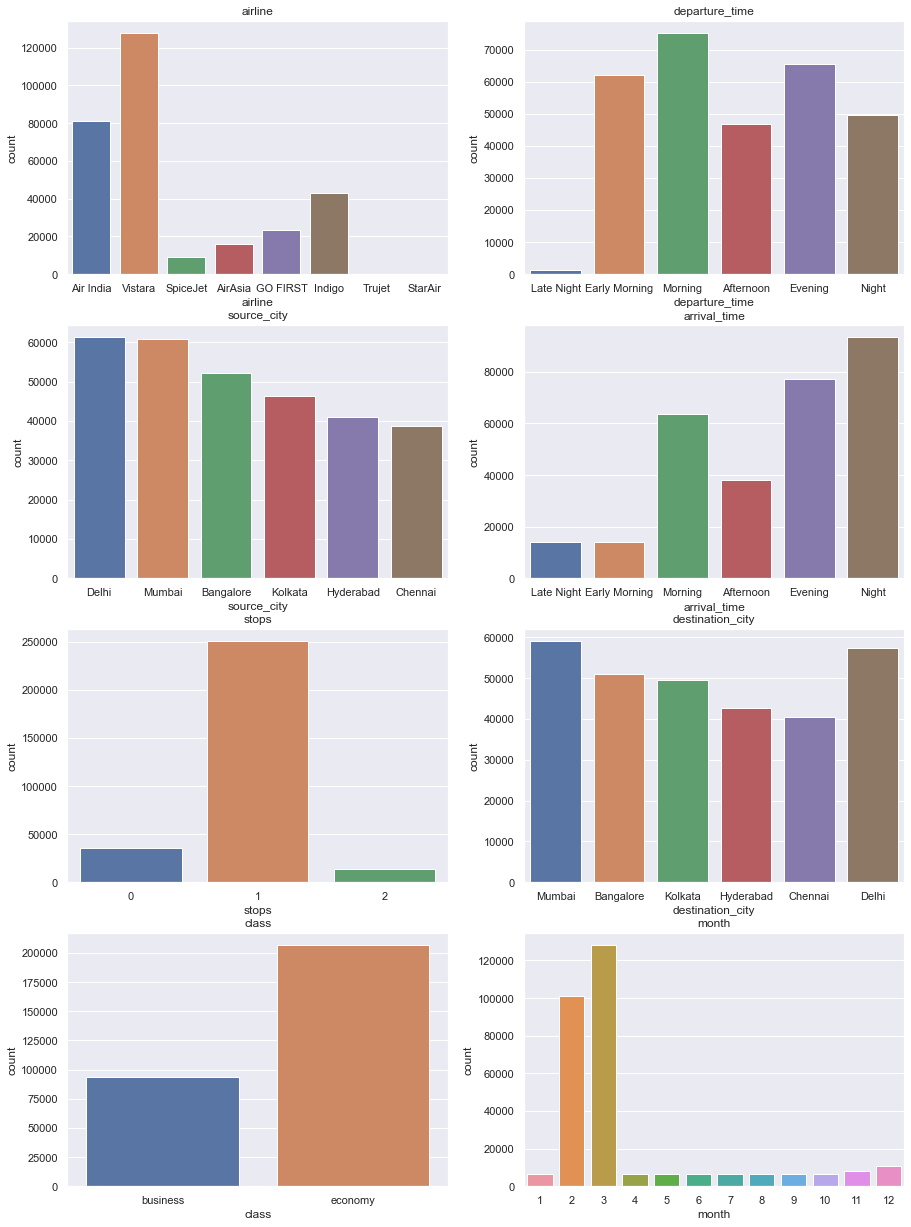

In [38]:
a=10
b=2
c=1
fig = plt.figure(figsize=(15,55))
for i in categorial:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    sns.countplot(data = df, x=i)
    c = c + 1

The above plots are the count plots for each categorical variable. From the above plots we can observe that:
- the mostly used airline is Vistara and second highest used airline is air india
- most of the plane departure during the morning hours and in the evening hour and it is very rare that the a flight departure late night
- most of the flight are starts from dehli and mumbai
- the arrival time of most of the flights are in night and in evening
- there is usually one stop is involves in most of the flights
- the destination city is in most cases is mumbai and dehli
- most of the peopl travel through economy
- in the month of feburary and march most of the flights occurs

From the pie chart we can see these values in percents

#### Pie Chart

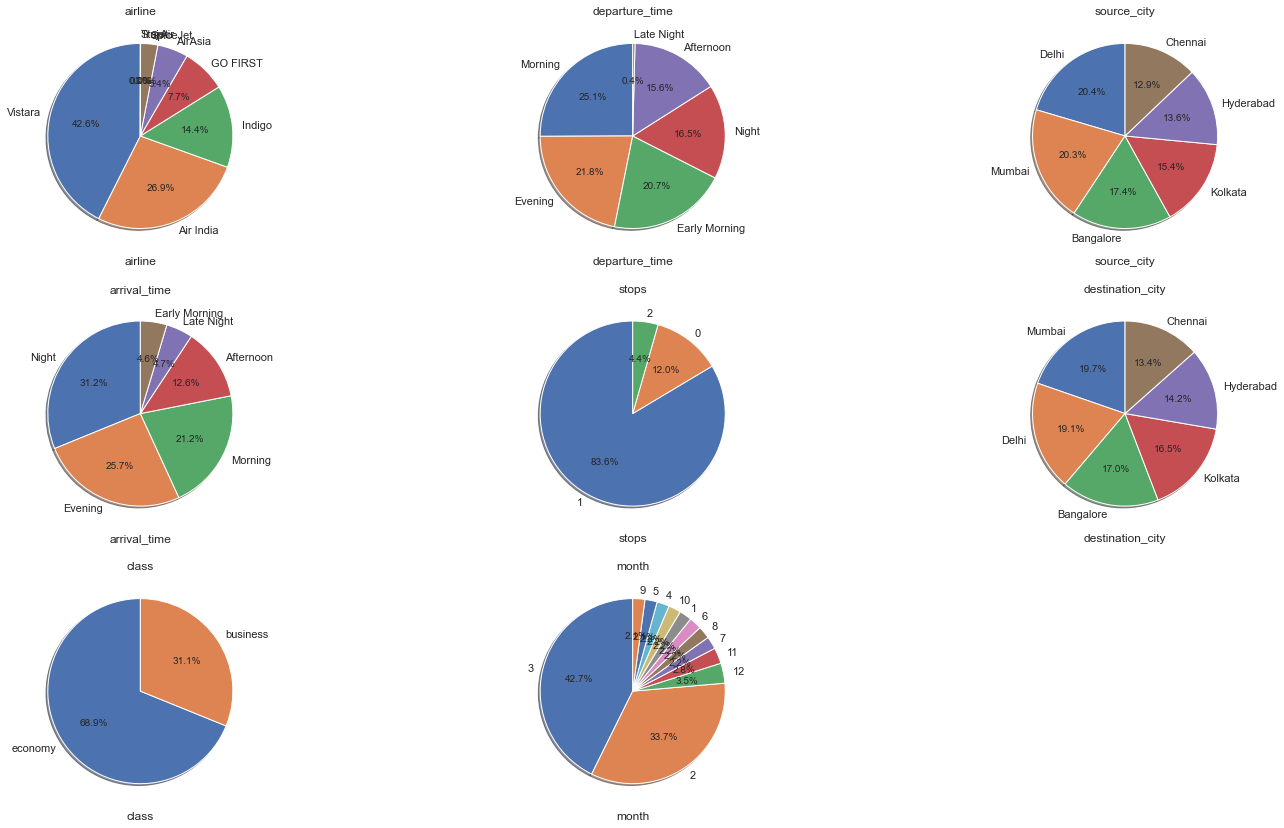

In [39]:
a=8
b=3
c=1
fig = plt.figure(figsize=(25,40))
for i in df[categorial]:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i))
    plt.xlabel(i)
    plt.pie(df[i].value_counts(),autopct='%1.1f%%',startangle=90,shadow=True,labels=df[i].value_counts().keys().values)
    c = c + 1

**Numerical Plot**

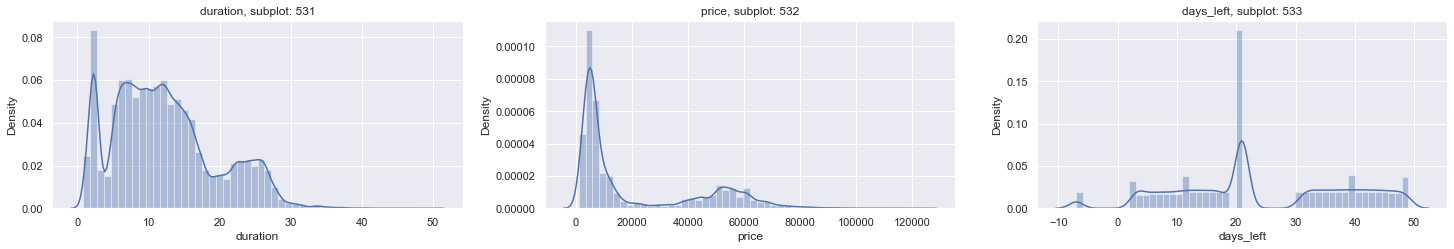

In [40]:
a=5
b=3
c=1
fig = plt.figure(figsize=(25,20))
for i in numerical:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.distplot(df[i])
    c = c + 1

The above plots are the distribution plots built on the numerical variables. these plots illustrate the distribution of the values of each column. each specific column subplot represent the distribution plot of each column. from the above plots we can see that:
- from the duration plot we can see that most of the flights duration are below 15 hours and very few have 30 hours
- most of the flights prices are below 25,000

### Bi-Variant Visualization 

Let's visualize the each column in terms of Class

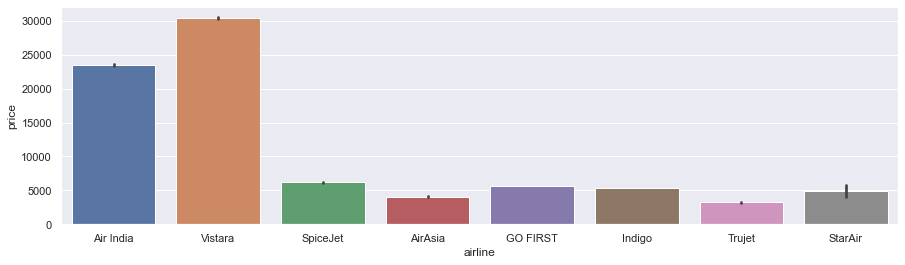

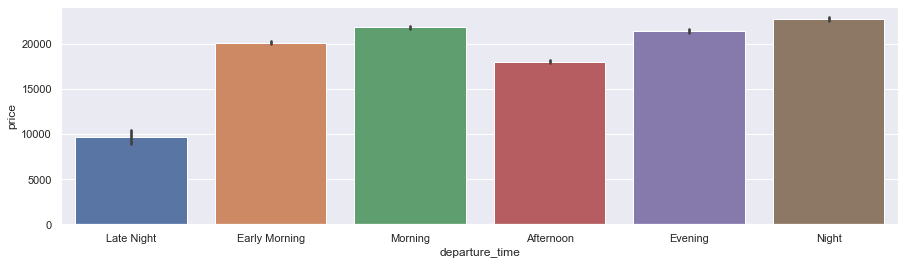

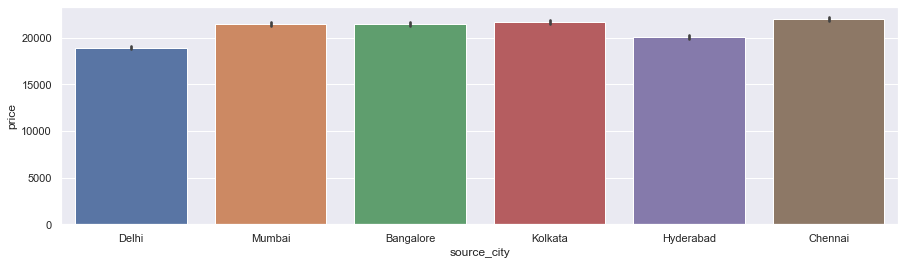

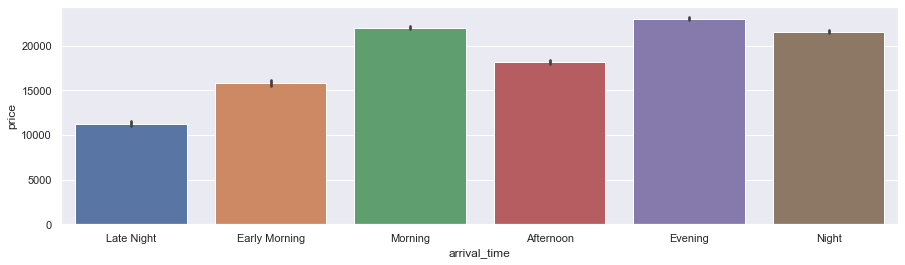

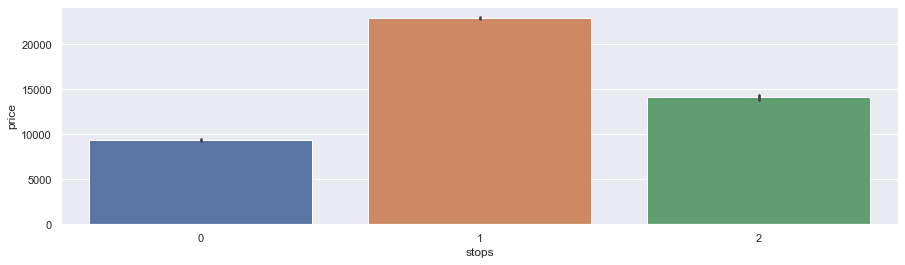

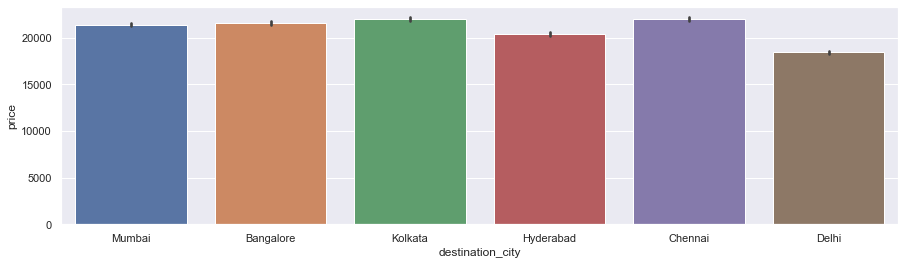

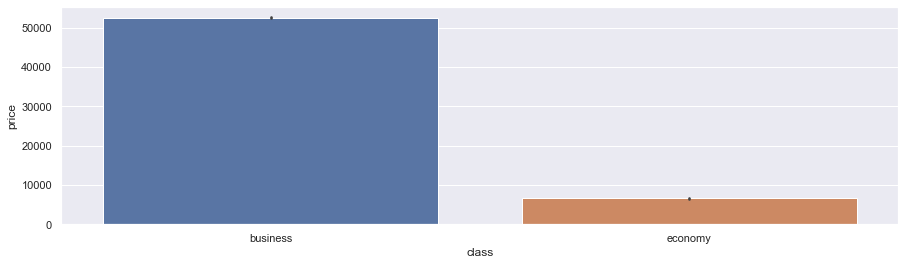

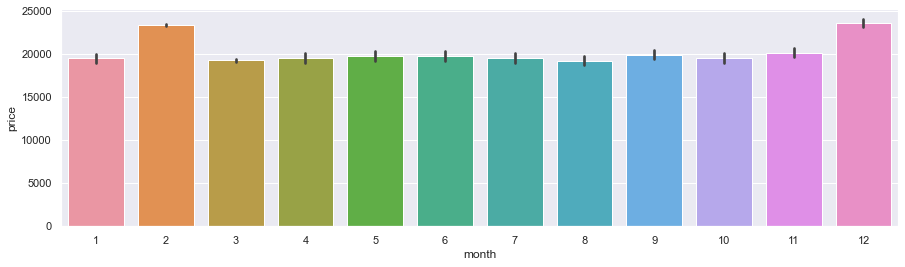

In [41]:
for i in categorial:
    fig , ax=plt.subplots(figsize=(15,4))
    sns.barplot(data = df, x = i ,y = 'price')
    ax.set_ylabel('price')
    ax.set_xlabel(i)

the above plots compare the all of the independent categorical variable with the target variable that is price. From these plot following patterns can be observes:
- the airline vistara and air india have high prices compare to other airlines
- the late night departure time of flights are least expensive and after that the afternoon flights. whereas the morning and night flights are most expensives
- the flights from chennai are slightly more expensive compare to mumbai, bangalore and kolkata. whereas the dehli source flights are least expensive
- the late night arrival flights are also least expensive and this variable have same pattern asthe departure time
- flights with 1 stops are most expensice and flights with 0 stops are least expensive
- the destination city have same pattern as source city
- business class is more expensive then economy
- flights in feburary and december are significantly more expensive compare to other months

ValueError: cannot reindex on an axis with duplicate labels

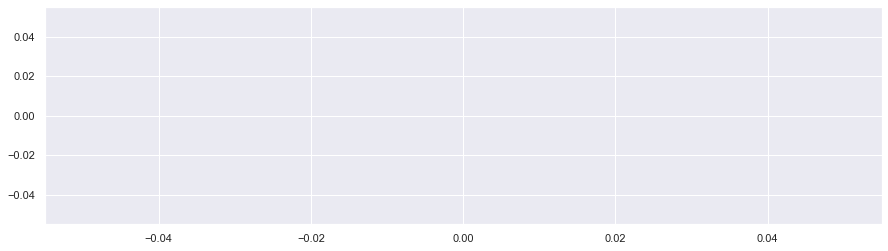

In [42]:
for i in ['duration', 'days_left']:
    fig , ax=plt.subplots(figsize=(15,4))
    sns.lineplot(data=df,x=i,y='price')
    ax.set_ylabel('price')
    ax.set_xlabel(i)

From the above plots we will see how the numerical variables varies with the prices
- from the duration plot we can see that as the duration of the flight increases the prices also increases
- from the days_left column we can see that the less the number of days left in the flights the more high the price gets.

## Features Encoding

**Manual Encoding**

In [ ]:
df["departure_time"].replace({'Late Night':0,'Early Morning':1,'Morning':2,
                               'Afternoon':3,'Evening':4,'Night':5},inplace=True)
df["arrival_time"].replace({'Late Night':0,'Early Morning':1,'Morning':2,
                             'Afternoon':3,'Evening':4,'Night':5},inplace=True)
df["class"].replace({"economy":0,"business":1},inplace=True)

**One Hot Encoding**

In [45]:
ohe = OneHotEncoder()
df[list(df["airline"].unique())] = ohe.fit_transform(df[["airline"]]).A # making sparse metrics to metrics
df = pd.concat([df,pd.get_dummies(df["destination_city"],prefix = "destination_city")], axis = 1)
df = pd.concat([df,pd.get_dummies(df["source_city"],prefix = "source_city")], axis = 1)
df.drop(["airline","source_city","destination_city"],axis = 1,inplace=True)
df.head()

,departure_time,duration,stops,arrival_time,price,class,days_left,month,Air India,Vistara,SpiceJet,AirAsia,GO FIRST,Indigo,Trujet,StarAir,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,Evening,2.00,0,Night,25612,business,20,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0
1,Evening,2.25,0,Night,25612,business,20,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0
2,Night,24.75,1,Night,42220,business,20,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0
3,Night,26.50,1,Night,44450,business,20,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0
4,Evening,6.67,1,Night,46690,business,20,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,0,0


In [46]:
df.shape

(300261, 28)

**Correlation Plot**

Lets check the correlation values of each variable

In [47]:
corr = df.corr(method = 'pearson')
corr['price'].abs().sort_values(ascending=False)

price                         1.000000
StarAir                       0.360958
AirAsia                       0.280739
duration                      0.204473
SpiceJet                      0.194101
Vistara                       0.176106
stops                         0.119798
GO FIRST                      0.113961
days_left                     0.072098
Air India                     0.070180
destination_city_Delhi        0.052398
source_city_Delhi             0.043151
destination_city_Kolkata      0.021063
source_city_Chennai           0.018840
destination_city_Chennai      0.018574
source_city_Kolkata           0.016236
destination_city_Bangalore    0.013857
month                         0.013426
source_city_Mumbai            0.013291
source_city_Hyderabad         0.013124
source_city_Bangalore         0.011552
destination_city_Mumbai       0.010587
Indigo                        0.010018
Trujet                        0.009082
destination_city_Hyderabad    0.008506
Name: price, dtype: float

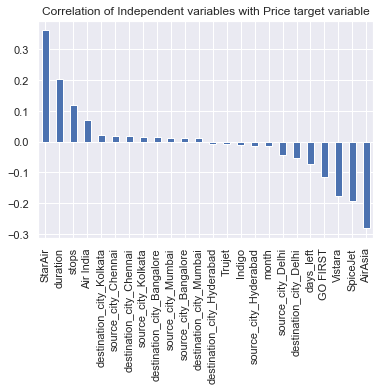

In [48]:
corr['price'].sort_values(ascending=False)[1:].plot(kind='bar');
plt.title('Correlation of Independent variables with Price target variable');

From the above plot we can see that the class, StarAir, AirAsia and duration have good correlation with the price target variable

### Random Sampling

Since the size of the data is too big we will sub sample thedataset for the ease of processing

In [43]:
sub_df = df.sample(n=15000)

### Splitting features set and target data

In [44]:
y = sub_df['price'].values
x = sub_df[['departure_time', 'duration', 'stops', 'arrival_time', 'class',
       'days_left', 'month', 'Air India', 'Vistara', 'SpiceJet', 'AirAsia',
       'GO FIRST', 'Indigo', 'Trujet', 'StarAir', 'destination_city_Bangalore',
       'destination_city_Chennai', 'destination_city_Delhi',
       'destination_city_Hyderabad', 'destination_city_Kolkata',
       'destination_city_Mumbai', 'source_city_Bangalore',
       'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai']]
y=y.reshape(-1,1)

KeyError: "['Air India', 'Vistara', 'SpiceJet', 'AirAsia', 'GO FIRST', 'Indigo', 'Trujet', 'StarAir', 'destination_city_Bangalore', 'destination_city_Chennai', 'destination_city_Delhi', 'destination_city_Hyderabad', 'destination_city_Kolkata', 'destination_city_Mumbai', 'source_city_Bangalore', 'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad', 'source_city_Kolkata', 'source_city_Mumbai'] not in index"

### Standardization

In [ ]:
scaler = StandardScaler()
scale_x = scaler.fit_transform(x)

In [ ]:
scale_y = scaler.fit_transform(y)

## Dimension Reduction Through PCA

**Grid Search For PCA**

In [ ]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline([
    ('pca', PCA()),
    ('linear', LinearRegression())
])

# Define the grid search parameters
param_grid = {
    'pca__n_components': [2, 4, 6, 8, 10,11,12]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid_search.fit(scale_x, y)

# Print the best parameters and the corresponding mean cross-validated score
print("Best parameters:", grid_search.best_params_)

**PCA**

In [ ]:
pca = PCA()
pca_x = pca.fit_transform(scale_x)

n_components = 12  # Number of top principal components to select
scale_pca_x = pca_x[:, :n_components]

### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
xtrain , xtest , ytrain, ytest =train_test_split(scale_pca_x,scale_y,
                                                 test_size=0.2,
                                                 random_state=42 )
print("xtrain shape : ", xtrain.shape) 
print("xtest shape  : ", xtest.shape) 
print("ytrain shape : ", ytrain.shape) 
print("ytest shape  : ", ytest.shape) 

# MODEL IMPLEMENTATIONS

Here we will implement 4 regression models to predict the Price of an airline ticket and evaluate it through different measures and visualization. After that we will adjust the hyper parameter of each model to improve each model predictions

## MODEL 1: Linear Regression

Since there are no hyper parameters to changes, we will not implement the grid search on linear regression

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression() 
model=regressor.fit(xtrain, ytrain) 

# predicting the test set results 
y_pred = regressor.predict(xtest) 

**Testing LR**

In [ ]:
model_efficiency= model.score(xtrain,ytrain)
print("Apartment Data")
print("Model Efficiency: ", model_efficiency)
print("Model Accuracy: ",model.score(xtest, ytest) * 100)
mse = mean_squared_error(ytest, y_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

In [ ]:
modelresult = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': y_pred.flatten().round(2)})

**Line plot of top 200 Data rows**

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=modelresult.head(200))

**Bar plot of Top 50 Data rows**

In [ ]:
modelresult.head(50).plot(kind='bar',figsize=(16,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

the training accuracy of linear regression is 54 with testing accuracy is 55 and mean square error is 0.457. this indicate that linear model doesnot work well on our dataset

## MODEL 2: Support Vector Regressor

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

model_svr = SVR(kernel = 'linear',gamma = 0.05).fit(xtrain, ytrain) 

ypred_svr = model_svr.predict(xtest) 

### Testing SVR

In [ ]:
model_efficiency= model_svr.score(xtrain,ytrain)
print('Model Efficiency: ',model_efficiency)

In [ ]:
print("Accuracy: ",model_svr.score(xtest, ytest) * 100)

In [ ]:
mse = mean_squared_error(ytest, ypred_svr)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

In [ ]:
modelresult = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': ypred_svr.flatten().round(2)})

**Line plot of top 200 Data rows**

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=modelresult.head(200))

**Bar plot of Top 50 Data rows**

In [ ]:
modelresult.head(50).plot(kind='bar',figsize=(16,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

From the above Evaluation we can see that SVR model testing accuracy is 52 with 0.489 mean square errors

### Adjusting Hyperparameters

Here we change the kernel svr rbf and change the gamma value to scale 

In [ ]:
gs_svr = SVR(kernel = 'rbf', gamma = 'scale')
gs_svr.fit(xtrain, ytrain)
ypred_gs_svr = gs_svr.predict(xtest)

In [ ]:

model_efficiency= gs_svr.score(xtrain,ytrain)
print('Model Efficiency: ',model_efficiency)

print("Accuracy: ",gs_svr.score(xtest, ytest) * 100)

mse = mean_squared_error(ytest, ypred_gs_svr)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Here we can see the our model accuracy is improved to 93.4% and mse reduce to 0.067. the high accuracy with rbf kernal indicate that our data is not linearly seperable

In [ ]:
aa  = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': ypred_svr.flatten().round(2), 'adj_Predicted': ypred_gs_svr.flatten().round(2)})

In [ ]:
aa.head(30).plot(kind='line' )

From the above plot we can see that the adjusted model line are more closer to the actual line

## MODEL 3: Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(xtrain, ytrain)

ypred = gbr.predict(xtest)

## Testing GBR

In [ ]:
model_efficiency= gbr.score(xtrain,ytrain)
print('Model Efficiency: ',model_efficiency)

In [ ]:
# print metric to get performance
print("Accuracy: ",gbr.score(xtest, ytest) * 100)

In [ ]:
mse = mean_squared_error(ytest, ypred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

In [ ]:
modelresult = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': ypred.flatten().round(2)})

**Line plot of top 200 Data rows**

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=modelresult.head(200))

**Bar plot of Top 50 Data rows**

In [ ]:
modelresult.head(50).plot(kind='bar',figsize=(16,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

From the above Evaluation we can see that GBR model accuracy is 87.1 with 0.131 mean square error

### Adjusting Hyperparameters

In [ ]:
params = {
    "n_estimators": 1500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

gbr_2 = GradientBoostingRegressor(**params)
gbr_2.fit(xtrain, ytrain)

ypred_gbr_2 = gbr_2.predict(xtest)

In [ ]:
model_efficiency= gbr_2.score(xtrain,ytrain)
print('Model Efficiency: ',model_efficiency)

# print metric to get performance
print("Accuracy: ",gbr_2.score(xtest, ytest) * 100)

In [ ]:
mse = mean_squared_error(ytest, ypred_gbr_2)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Here we can see the our model accuracy is improved to 91 and mse reduce to 0.0827


In [ ]:
aa  = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': ypred.flatten().round(2), 'adj_Predicted': ypred_gbr_2.flatten().round(2)})

aa.head(30).plot(kind='line' )


From the above plot we can see that the adjusted model line are more closer to the actual line. and it do follow the pattern of actual data.

## MODEL 4: Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
model_dt = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
model_dt.fit(xtrain, ytrain)

ypred_dt = model_dt.predict(xtest)

### Testing DTR

In [ ]:
model_efficiency= model_dt.score(xtrain,ytrain)
print('Model Efficiency: ',model_efficiency)

# print metric to get performance
print("Accuracy: ",model_dt.score(xtest, ytest) * 100)

mse = mean_squared_error(ytest, ypred_dt)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

In [ ]:
modelresult = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': ypred_dt.flatten().round(2)})

**Line plot of top 200 Data rows**

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(data=modelresult.head(200))

**Bar plot of Top 50 Data rows**

In [ ]:
modelresult.head(50).plot(kind='bar',figsize=(16,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

From the above Evaluation we can see that Decision Tree model doesnot preform well, the model training accuracy is 99.9 percent and testing accuracy is 89.25%  with 0.114 mean square error

### Adjusting Hyperparameters

In [ ]:
param = {
    'criterion': ['squared_error', 'poisson'],
    'splitter': ['best','random'],
    'max_depth': [3,4,5,6,7,8,10,15,20],
    'ccp_alpha': [0,0.1,0.01],
    'random_state' : [0,2,4,6]
}

gs_dt = GridSearchCV(DecisionTreeRegressor(), param, cv=5)
gs_dt.fit(xtrain, ytrain)

In [ ]:
print(gs_dt.best_params_) 
print(gs_dt.best_estimator_)

The above parameters values are the best hyperparameters found by the grid search

In [ ]:
ypred_gs_dt = gs_dt.predict(xtest)

In [ ]:
model_efficiency= gs_dt.score(xtrain,ytrain)
print('Model Efficiency: ',model_efficiency)

# print metric to get performance
print("Accuracy: ",gs_dt.score(xtest, ytest) * 100)

mse = mean_squared_error(ytest, ypred_gs_dt)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Here we can see the our model accuracy is improved to 89.33 and mse reduce to 0.1096


In [ ]:
aa  = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': ypred_dt.flatten().round(2), 'adj_Predicted': ypred_gs_dt.flatten().round(2)})

aa.head(80).plot(kind='line' )


From the above plot we can see that the adjusted model line is slightly more closer to the actual line.

### Analysis:
Here we apply 4 different ML models to predict the price of airline ticket. all of the 4 models are applied and evaluated through its model efficiency, model accuracy and mean square error. All of the 4 model's performance is improved by adjusting the hyperparameters. best set of hyperparameters are found through two ways. First, manually change the hyperparameters values to find the best set. second, gridsearch technique is use to find the best set of hyperparameters. 

All of the four model perfromance is improved by adjusting the hyperparameter. amoung all of the model the Suport Vector Regressor with RBF as its kernel function performs the best.